In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
from functions import*
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for training.")


Using cuda for training.


## 데이터 라벨링 

In [4]:
def FilterLargeNum(raw_data):
    """
    raw data를 입력받아 큰 숫자를 원래 값 범위로 치환해서 채워준 후 해당 갯수 표시 하고 수저오딘 리스트 반환 
    """
    count_error = 0
    raw_data_new = []
    for i in range(len(raw_data)):
        if raw_data[i] >1000:
            tmp = raw_data[i]
            print(tmp)
            count_error+=1
            if i == 0:
                tmp = raw_data[i+1]
                count_error -=1
            while tmp > 1000:
                tmp = tmp//10
            raw_data_new.append(tmp)  
        else : 
            raw_data_new.append(raw_data[i])
    print("sdljflskdjflsdkjflsjdfj count_error = "+str(count_error))
    return raw_data_new 
    
        

In [5]:
def GenerateLabelList(raw_data,start_idx,end_idx=0,threshold = -120):
    """
    raw_data 특정 섹션 정답 라벨 리스트 반환하고 plot
    threshold : 인덱스간 차이 
    """
    label_lst = []
    t_idx = []  
    if end_idx == 0 :
        end_idx = start_idx + 1000
    for i in range(len(raw_data[start_idx:end_idx])):
        t_idx.append(start_idx+i)
    for i in range(len(raw_data[start_idx:end_idx])):
        if raw_data[start_idx+i]-raw_data[start_idx+i-1]<threshold and raw_data[start_idx+i+1]-raw_data[start_idx+i]>threshold: 
            label_lst.append(start_idx+i+1)
    return(label_lst)

In [19]:
def InterpolationErrorData(label_lst,threshold = 1.3):
    label_interpolated_lst = [label_lst[0],label_lst[1]]
    for i in range(2,len(label_lst)):
        if label_lst[i]-label_lst[i-1]>(label_lst[i-1]-label_lst[i-2])*threshold:
            if label_lst[i]-label_lst[i-1]>(label_lst[i-1]-label_lst[i-2])*threshold and label_lst[i]-label_lst[i-1]<(label_lst[i-1]-label_lst[i-2])*(threshold+1.1) : 
                label_interpolated_lst.append((label_lst[i]-label_lst[i-1])//2)
                label_interpolated_lst.append(label_lst[i-1])
            elif  label_lst[i]-label_lst[i-1]>(label_lst[i-1]-label_lst[i-2])*(threshold+1.1) and label_lst[i]-label_lst[i-1]<(label_lst[i-1]-label_lst[i-2])*(threshold+2.2):
                label_interpolated_lst.append((label_lst[i]-2*label_lst[i-1])//3)
                label_interpolated_lst.append((2*label_lst[i]-label_lst[i-1])//3)
                label_interpolated_lst.append(label_lst[i-1])
            else:
                label_interpolated_lst.append(label_lst[i-1])
                print(str(label_lst[i-1])+"   ERRRRRRRRRRRRRRRRRRRORRRRRRRRRR   "+str(label_lst[i-1]))
        else : 
            label_interpolated_lst.append(label_lst[i-1])
    label_interpolated_lst.append(label_lst[-1])
    return label_interpolated_lst

def DeleteErrorLabelLst(label_lst,threshold = 1.3):
    Deleted_label_lst= [label_lst[0]]
    eliminated_label_lst = []
    for i in range(2,len(label_lst)):
        if label_lst[i]-label_lst[i-1]<(label_lst[i-1]-label_lst[i-2])/threshold:
            eliminated_label_lst.append(label_lst[i-1])
            # print(label_lst[i-1])
            continue
        else:
            Deleted_label_lst.append(label_lst[i-1])
    Deleted_label_lst.append(label_lst[-1])
    # print(eliminated_label_lst)
    return Deleted_label_lst

In [8]:
def ShowLabelList(raw_data, label_lst, start_idx, end_idx=0, scale=1):
    if end_idx == 0:
        end_idx = start_idx + 1000

    # 인덱스 범위를 벗어나지 않는 레이블만 필터링
    filtered_labels = [label for label in label_lst if start_idx <= label < end_idx]

    t_idx = list(range(start_idx, end_idx))
    
    plt.figure(figsize=(15*scale, 7*scale))
    plt.grid()
    plt.plot(t_idx, raw_data[start_idx:end_idx], label="Raw Data")
    
    # 필터링된 레이블에 대해 점 찍기
    for label in filtered_labels:
        plt.scatter(label, raw_data[label], color='r', label="Label" if filtered_labels.index(label) == 0 else "")

    plt.legend()
    plt.show()


In [9]:
raw_hr_data = FilterLargeNum(LoadCsvToList("g_1.csv",'data//'))

7203
174252
sdljflskdjflsdkjflsjdfj count_error = 1


In [20]:
label_lst = []
for i in range(len(raw_hr_data)//1000):
    result = GenerateLabelList(raw_hr_data, 0000+1000*i, threshold=-120)
    label_lst.extend(result)
label_filtered_lst1 = DeleteErrorLabelLst(label_lst)

In [22]:
print(label_filtered_lst1)

[1, 3, 14, 106, 184, 262, 341, 420, 497, 574, 650, 726, 803, 880, 956, 1033, 1109, 1183, 1257, 1332, 1407, 1483, 1557, 1630, 1704, 1777, 1850, 1923, 1995, 2067, 2138, 2210, 2280, 2350, 2421, 2492, 2561, 2632, 2700, 2770, 2840, 2908, 2977, 3048, 3116, 3253, 3390, 3457, 3525, 3593, 3663, 3731, 3799, 3867, 3934, 4001, 4068, 4136, 4202, 4269, 4335, 4401, 4468, 4534, 4602, 4667, 4732, 4799, 4865, 4931, 4997, 5062, 5129, 5194, 5259, 5325, 5393, 5457, 5522, 5588, 5654, 5719, 5784, 5850, 5914, 5980, 6046, 6111, 6177, 6243, 6309, 6374, 6440, 6505, 6574, 6639, 6705, 6770, 6836, 6901, 6966, 7030, 7095, 7160, 7224, 7418, 7483, 7547, 7612, 7676, 7741, 7805, 7870, 7936, 7999, 8063, 8127, 8191, 8256, 8321, 8386, 8447, 8510, 8573, 8639, 8703, 8766, 8829, 8893, 8957, 9021, 9084, 9148, 9211, 9276, 9339, 9404, 9465, 9528, 9592, 9656, 9720, 9783, 9847, 9911, 9974, 10038, 10101, 10164, 10229, 10292, 10358, 10423, 10486, 10550, 10613, 10677, 10740, 10805, 10868, 10931, 10996, 11060, 11122, 11186, 11250, 113

In [68]:
for i in range(len(label_filtered_lst1)):
    if label_filtered_lst1[i] > 36224:
        break
label_filtered_lst1=label_filtered_lst1[:i]+label_filtered_lst1[i+1:]

In [69]:
label_filtered_lst1 = label_filtered_lst1[2:]

In [133]:
for i in range(len(label_filtered_lst1)):
    if label_filtered_lst1[i] > 100650:
        break
label_filtered_lst1=label_filtered_lst1[:i]+label_filtered_lst1[i+1:]

In [153]:
for i in range(len(label_filtered_lst1)):
    if label_filtered_lst1[i] > 116300:
        break
label_filtered_lst1=label_filtered_lst1[:i]+label_filtered_lst1[i+1:]

In [163]:
for i in range(len(label_filtered_lst1)):
    if label_filtered_lst1[i] > 116700:
        break
label_filtered_lst1=label_filtered_lst1[:i]+label_filtered_lst1[i+4:]

In [ ]:
null_lst = [32360,43100[66900,66700], [71450,71500],74950,[116550,116600]]

In [164]:
tmp = []
t1 = [3186, 3320, 7296, 14956 , 15021, 15800, 15863, 17933, 17998, 18060 ,19078 ,19144]
t2 = [22491, 22552, 29312 ,29375, 36219, 38640 ,41141, 41201 ,43163 ,46500 ,46439 ,49233 ,49295]
t3 = [54310 ,54372 ,58182 ,58240, 62522, 62582 ,64306 ,64367 ,67089 ,67150 ,67865 ,67920, 68747 ,68808]
t4 = [71546, 75015 ,81141, 82212 ,82271, 88721, 88776 ,89294 ,89351 ,100613 ,100670, 100905 ,101254 ,101331 ,103315, 103373]
t5 = [113808 ,113867, 116298 ,116694]
tmp = t1+t2+t3+t4+t5+label_filtered_lst1
tmp.sort()

In [177]:
for i in range(len(tmp)):
    if tmp[i] > 66940:
        break
tmp=tmp[:i]+tmp[i+1:]

In [183]:
for i in range(len(tmp)):
    if tmp[i] > 101325:
        break
tmp=tmp[:i]+tmp[i+1:]

In [185]:
tmp = tmp+ [7354, 101311]
tmp.sort()

In [191]:
for i in range(len(tmp)):
    if tmp[i] > 32350:
        break
tmp=tmp[:i]+tmp[i+1:]

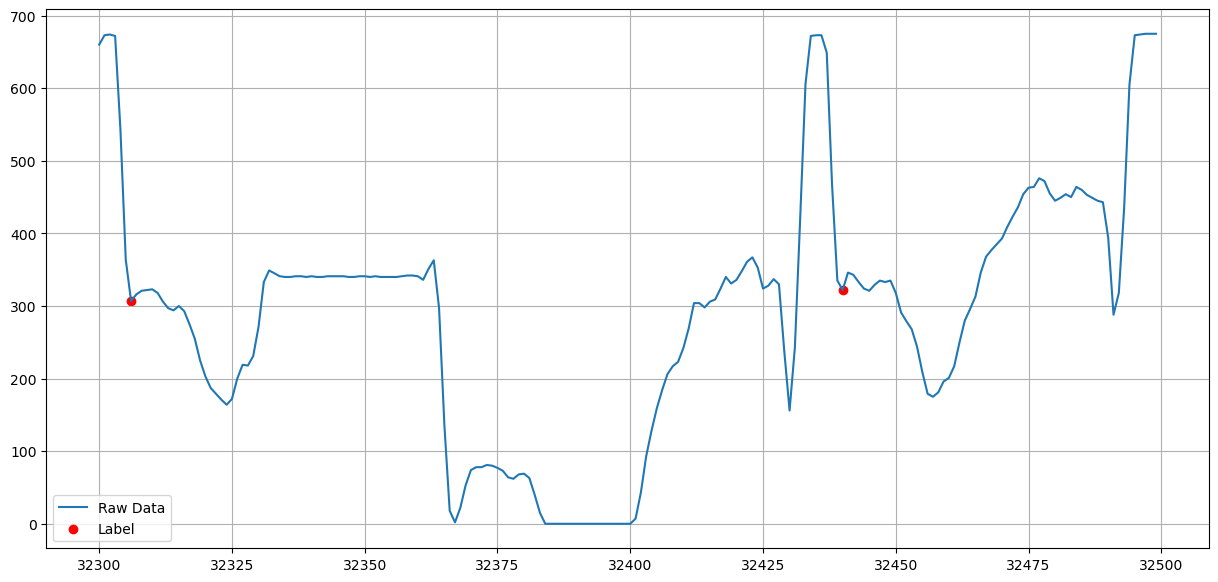

In [192]:
ShowLabelList(raw_hr_data, tmp,32300,32500)

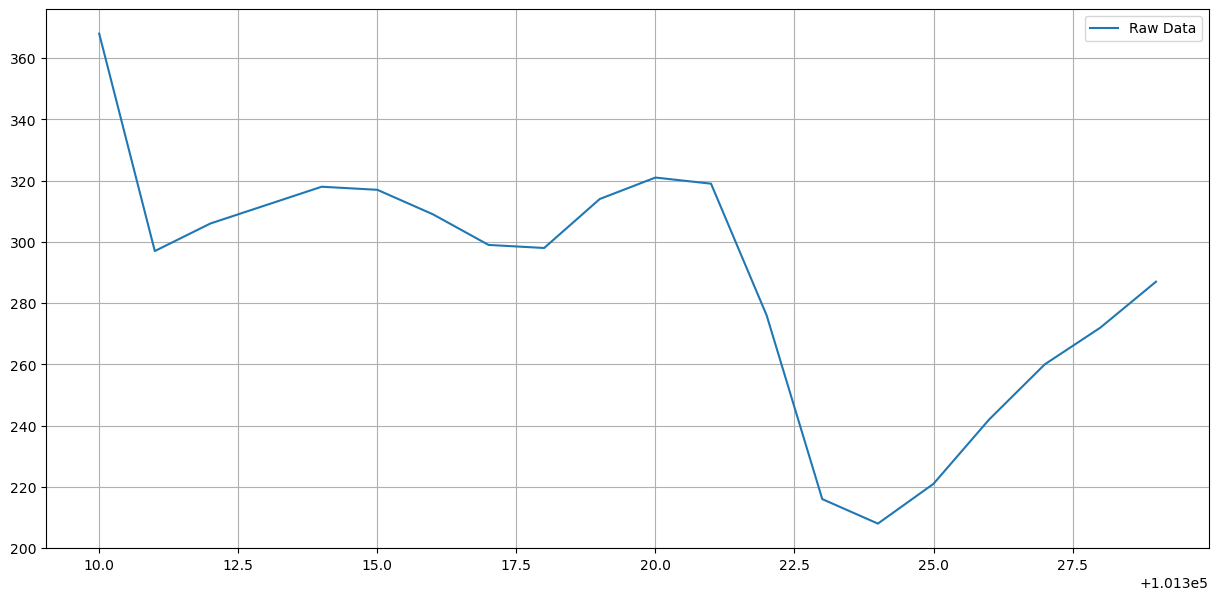

In [184]:
ShowLabelList(raw_hr_data, tmp,101310,101330)